# FastText

단어를 벡터로 만드는 또 다른 방법으로는 페이북에서 개발한 FastText가 있습니다. Word2Vec 이후에 나온 것이기 대문에, 메커니즘 자체는 Word2Vec의 확장버전이라고 볼 수 있습니다. Word2Vec과의 가장 큰 차이점이라면 Word2Vec은 단어를 **쪼갤 수 없는 단위**로 생각한다면, FastText는 하나의 단어 안에도 여러 단어들이 존재하는 것으로 간주합니다. 내부 단어, 즉 서브워드를 고려하여 학습합니다.

## 1. 내부 단어(Subword)의 학습

FastText에서는 각 단어는 글자 단위의 n-gram의 구성으로 취급합니다. n을 몇으로 결정하는지에 따라서 단어들이 얼마나 분리되는지 결정됩니다. 예를 들어서 tri-gram인 경우, apple은 app, ppl, ple로 분리하고 이들을 벡터로 만듭니다. 더 정확히는 시작과 끝을 의미하는 <,>를 도입하여 아래의 5개 내부 단어 토큰을 벡터로 만듭니다.

```py
# n=3인 경우
<ap, app, ppl, ple, le>
```

그리고 여기에 추가적으로 하나를 더 벡터화 하는데, 기존 단어에 <와 >를 붙인 토큰입니다.

```py
# 특별 토큰
<apple>
```

다시 말해 n=3인 경우, FastText는 단어 apple에 대해서 다음의 6개의 토큰을 벡터화 하는 것입니다.

```py
# n=3인 경우
<ap, app, ppl, ple, le>, <apple>
```

그런데 실제 사용할 때는 n의 최소값과 최대값으로 범위를 설정할 수 있는데, 기본값으로는 각각 3과 6으로 설정되어져 있습니다. 다시 말해 최소값 = 3, 최대값 = 6인 경우라면, 단어 apple에 대해서 FastText는 아래 내부 단어들을 벡터화 합니다.

```py
# n = 3 ~ 6인 경우
<ap, app, ppl, ple, le>, <app, appl, pple, ple>, <appl, pple>, ..., <apple>
```

여기서 내부 단어들을 벡터화한다는 의미는 저 단어들에 대해서 Word2Vec을 수행한다는 의미입니다. 위와 같이 내부 단어들의 벡터값을 얻었다면, 단어 apple의 벡터값은 저 위 벡터값들의 총 합으로 구성합니다.

```py
apple = <ap + app + ppl + ple + le> + <app + pple + ple> + <appl + pple> + ... + <apple>
```

그리고 이런 방법은 Word2Vec에선 얻을 수 없었던 강점을 가집니다.

## 2. 모르는 단어(OOV)에 대한 대응
FastText의 인공 신경망을 학습한 후에는 데이터 셋의 모든 단어의 각 n-gram에 대해서 워드 임베딩이 진행됩니다. 이렇게 되면 장점은 데이터 셋만 충분하다면 위와 같은 내부 단어를 통해 모르는 단어, 즉 OOV에 대해서도 다른 단어와의 유사도를 계산할 수 있다는 점입니다.

가령, FastText에서 birthplace란 단어를 학습하지 않은 상태라고 가정해봅시다. 그럼에도 다른 단어에서 birth와 place라는 내부 단어가 있었다면, FastText는 birthplace의 벡터를 얻을 수 있습니다. 이는 모르는 단어에 제대로 대처할 수 없는 Word2Vec, GloVe와는 다른점입니다.

## 3. 단어 집합 내 빈도수가 적었던 단어(Rare Word)에 대한 대응
Word2Vec의 경우에는 등장 빈도 수가 적은 단어(rare word)에 대해서는 임베딩의 정확도가 높지 않다는 단점이 있었습니다. 참고할 수 있는 경우의 수가 적다보니 정확하게 임베딩이 되지 않는 경우입니다. 

하지만 FastText의 경우, 만약 단어가 희귀 단어라도, 그 단어의 n-gram이 다른 단어의 n-gram과 겹치는 경우라면, Word2Vec과 비교하여 비교적 높은 임베딩 벡터값을 얻습니다.

FastText가 노이즈가 많은 코퍼스에서 감정을 가진 것 또한 이와 같은 이유입니다. 모든 훈련 코퍼스에 오타나 맞춤법이 틀린 단어가 없으면 이상적이겠지만, 실제 많은 비정형 데이터에는 오타가 섞여 있습니다. 그리고 오타가 섞인 단어는 당연히 등장 빈도수가 매우 적으므로 일종의 희귀 단어가 됩니다. 즉, Word2Vec에서는 오타가 섞인 단어는 임베딩이 제대로 되지 않지만 FastText는 이에 대해서도 일정 수준의 성능을 보입니다.

예를 들어, 단어 apple과 오타로 p를 한 번 더 입력한 appple의 경우에는 실제로 많은 개수의 동일한 n-gram을 가질 것입니다.

## Word2Vec과 비교

Word2Vec 모델을 빌드하기 위해 필요한 라이브러리를 임포트하고, 데이터 셋을 다운로드 받는다.

In [1]:
import re
from urllib import request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

### 1) 훈련 데이터 이해하기

In [2]:
# 데이터 다운로드
request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x1d0dcfc8190>)

훈련 데이터 파일은 xml 문법으로 작성되어 있어 자연어를 얻기 위해서는 전처리가 필요합니다. 얻고자 하는 실질적 데이터는 영어 문장으로만 구성된 내용을 담고 있는 `<content>와 </content>` 사이의 내용입니다. 전처리 작업을 통해 xml 문법들은 제거하고, 해당 데이터만 가져와야 합니다. 뿐만 아니라, `<content>와 </content>` 사이의 내용 중에는 (Laughter)나 (Applause)와 같은 배경음을 나타내는 단어도 등장하는데, 이 또한 제거해야 합니다.

### 2) 훈련 데이터 전처리하기

In [3]:
with open("./data/ted_en-20160408.xml", 'r', encoding="utf8") as targetXML:
    target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = "\n".join(target_text.xpath("//content/text()"))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [4]:
targetXML.close()

In [5]:
print(f"총 샘플의 개수 : {len(result)}")

총 샘플의 개수 : 273424


In [6]:
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [7]:
from gensim.models import Word2Vec, KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

Word2Vec의 파라미터는 다음과 같다.

- vector_size = 워드 벡터의 특징값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한(빈도가 적은 단어들은 학습하지 않음)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram

In [8]:
model_result = model.wv.most_similar('man')
model_result

[('woman', 0.8371988534927368),
 ('guy', 0.8034364581108093),
 ('lady', 0.7952240705490112),
 ('boy', 0.7742348313331604),
 ('girl', 0.7506352066993713),
 ('gentleman', 0.7435563802719116),
 ('soldier', 0.7342287302017212),
 ('kid', 0.7202671766281128),
 ('poet', 0.6995891332626343),
 ('david', 0.674483597278595)]

In [9]:
model.wv.save_word2vec_format("eng_w2v")


In [10]:
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v")

In [11]:
model_result = loaded_model.most_similar("man")

In [12]:
model_result

[('woman', 0.8371988534927368),
 ('guy', 0.8034364581108093),
 ('lady', 0.7952240705490112),
 ('boy', 0.7742348313331604),
 ('girl', 0.7506352066993713),
 ('gentleman', 0.7435563802719116),
 ('soldier', 0.7342287302017212),
 ('kid', 0.7202671766281128),
 ('poet', 0.6995891332626343),
 ('david', 0.674483597278595)]

## 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from urllib import request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [14]:
request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x1d106b47e20>)

In [16]:
train_data = pd.read_table("./data/ratings.txt")
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [17]:
train_data.shape

(200000, 3)

In [18]:
print(train_data.isnull().values.any())

True


In [19]:
train_data = train_data.dropna(how="any")
print(train_data.isnull().values.any())

False


In [20]:
train_data.shape

(199992, 3)

In [21]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")

In [22]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


학습 시에 사용하고 싶지 않은 단어들인 불용어를 제거하겠습니다. 형태소 분석기 Okt를 사용하여 각 문장에 대해서 일종의 단어 내지는 형태소 단위로 나누는 토큰화를 수행합니다.

In [23]:
from tqdm import tqdm

stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [12:23<00:00, 268.96it/s]


리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.338453538141525


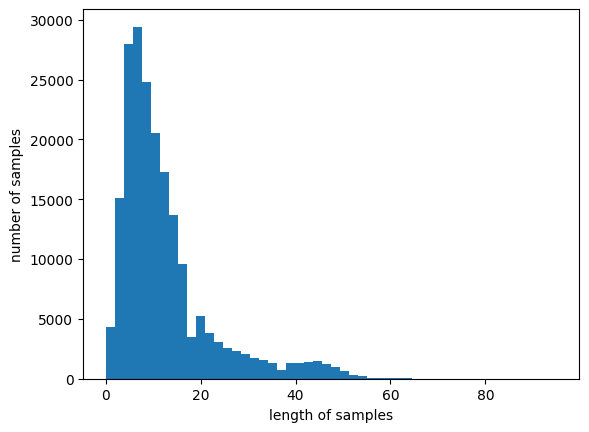

In [25]:
print(f"리뷰의 최대 길이 : {max(len(review) for review in tokenized_data)}")
print(f"리뷰의 평균 길이 : {sum(map(len, tokenized_data))/len(tokenized_data)}")
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [26]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [28]:
model.wv.vectors.shape

(17615, 100)

In [29]:
print(model.wv.most_similar("최민식"))

[('안성기', 0.8386850357055664), ('윤제문', 0.8297408223152161), ('최민수', 0.8248642683029175), ('조승우', 0.8233091235160828), ('한석규', 0.8223130106925964), ('설경구', 0.8205364942550659), ('송강호', 0.8191600441932678), ('김명민', 0.8190456032752991), ('정재영', 0.8120531439781189), ('문소리', 0.8094630241394043)]


In [30]:
model.wv.most_similar("히어로")

[('무협', 0.8518670201301575),
 ('슬래셔', 0.8488981127738953),
 ('호러', 0.8407148718833923),
 ('sf', 0.8368501663208008),
 ('블록버스터', 0.8258246779441833),
 ('물', 0.8193082213401794),
 ('느와르', 0.8188750743865967),
 ('정통', 0.8149327039718628),
 ('SF', 0.8052787780761719),
 ('무비', 0.791983962059021)]

## FastText VS Word2Vec

In [32]:
from gensim.models import FastText

model = FastText(result, vector_size=100, window=5, min_count=5, workers=4, sg=1)

In [33]:
w2v = KeyedVectors.load_word2vec_format("eng_w2v")

In [35]:
w2v.most_similar("electrofishing")

KeyError: "Key 'electrofishing' not present in vocabulary"

In [36]:
model.wv.most_similar("electrofishing")

[('electrolux', 0.862249493598938),
 ('electrolyte', 0.8597493767738342),
 ('electro', 0.8498822450637817),
 ('electroshock', 0.8377700448036194),
 ('electrochemical', 0.8372803926467896),
 ('electroencephalogram', 0.8271624445915222),
 ('electronic', 0.8244740962982178),
 ('electrogram', 0.820979654788971),
 ('electrons', 0.8195422887802124),
 ('electron', 0.81861412525177)]

Word2Vec은 학습하지 않은 단어에 대해서 유사한 단어를 찾아내지 못했지만, FastText는 유사한 단어를 계산해서 출력하고 있음을 볼 수 있다.

## 한국어에서의 FastText
한국어의 경우에도 OOV 문제를 해결하기 위해 FastText를 적용하고자 하는 시도들이 있었습니다.

### (1) 음절 단위
예를 들어서 음절 단위의 임베딩의 경우에 n=3일 때 "자연어 처리"라는 단어에 대해 n-gram을 만들어보면 다음과 같습니다.

> <자연 자연어, 연어처, 어처리, 처리>

### (2) 자모 단위
이제 더 나아가 자모 단위(초성, 중성, 종성 단위)로 임베딩하는 시도 또한 있었습니다. 음절 단위가 아니라, 자모 단위로 가게 되면 오타나 노이즈 측면에서 더 강한 임베딩을 기대해볼 수 있습니다. 예를 들어 "자연어처리"라는 단어에 대해서 초성, 중성, 종성을 분리하고, 만약 종성이 존재하지 않는다면 "_"라는 토큰을 사용한다고 가정한다면 "자연어처리"라는 단어는 아래와 같이 분리가 가능합니다.

> 분리된 결과 : ㅈ ㅏ _ ㅇ ㅕ ㄴ ㅇ ㅓ _ ㅊ ㅓ _ ㄹ ㅣ _

그리고 분리된 결과에 대해서 n=3일때, n-gram을 적용하여 임베딩을 한다면 다음과 같습니다.

> < ㅈ ㅏ, ㅈ ㅏ _, ㅏ _ ㅇ, ... 중략>